In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Flatten, BatchNormalization, Activation, Concatenate
from keras.optimizers import Adam
import tensorflow as tf

2024-07-31 00:29:00.900191: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 00:29:03.297955: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 00:29:03.299372: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 00:29:06.321512: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load data
message_file = pd.read_csv('AAPL_message_1.csv', header=None)
orderbook_file = pd.read_csv('AAPL_orderbook_1.csv', header=None)

In [3]:
# Data preprocessing
def preprocess_data(message_file, orderbook_file):
    message_file[0] = message_file[0] / 1000  # Convert time to seconds
    message_file[4] = message_file[4] / 10000  # Restore price to its actual value
    orderbook_file.iloc[:, ::4] = orderbook_file.iloc[:, ::4] / 10000  # Process order book prices
    return message_file, orderbook_file

message_file, orderbook_file = preprocess_data(message_file, orderbook_file)

In [4]:
print("Message file shape:", message_file.shape)
print("Orderbook file shape:", orderbook_file.shape)

Message file shape: (118497, 6)
Orderbook file shape: (118497, 4)


In [5]:
# Batch generator
def batch_generator(message_file, orderbook_file, batch_size, history_length):
    num_batches = (len(message_file) - history_length) // batch_size
    while True:
        for i in range(num_batches):
            batch_start = i * batch_size
            batch_end = batch_start + batch_size + history_length

            messages = message_file.iloc[batch_start:batch_end].values
            orderbooks = orderbook_file.iloc[batch_start:batch_end].values

            history_messages = np.array([messages[j:j+history_length] for j in range(batch_size)])
            history_orderbooks = np.array([orderbooks[j:j+history_length] for j in range(batch_size)])

            current_messages = messages[history_length:batch_size + history_length]
            current_orderbooks = orderbooks[history_length:batch_size + history_length]

            yield [history_messages, np.array(current_messages)], [history_orderbooks, np.array(current_orderbooks)]


In [6]:
class StockGAN:
    def __init__(self, history_length, noise_length, message_length, orderbook_length, batch_size):
        self.history_length = history_length
        self.noise_length = noise_length
        self.message_length = message_length
        self.orderbook_length = orderbook_length
        self.batch_size = batch_size
        self.lstm_out_length = 128
        
        self.build_generator()
        self.build_critic()
        
    def build_generator(self):
        history_input = Input(shape=(self.history_length, self.message_length))
        noise_input = Input(shape=(self.noise_length,))
        
        lstm_output = LSTM(self.lstm_out_length)(history_input)
        gen_input = Concatenate()([lstm_output, noise_input])
        
        x = Dense(256)(gen_input)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dense(self.message_length)(x)  # Ensure the output length matches the current message length
        gen_output = Activation('tanh')(x)
        
        self.generator = Model([history_input, noise_input], gen_output)
        
    def build_critic(self):
        history_input = Input(shape=(self.history_length, self.message_length))
        message_input = Input(shape=(self.message_length,))
        
        lstm_output = LSTM(self.lstm_out_length)(history_input)
        critic_input = Concatenate()([lstm_output, message_input])
        
        x = Dense(256)(critic_input)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dense(128)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        critic_output = Dense(1)(x)
        
        self.critic = Model([history_input, message_input], critic_output)
        
    def compile(self):
        self.generator.compile(optimizer=Adam(0.0001, beta_1=0.5), loss='binary_crossentropy')
        self.critic.compile(optimizer=Adam(0.0001, beta_1=0.5), loss=self.wasserstein_loss)
        
    def wasserstein_loss(self, y_true, y_pred):
        return tf.reduce_mean(y_true * y_pred)
        
    def train(self, message_file, orderbook_file, epochs, batch_size):
        batch_gen = batch_generator(message_file, orderbook_file, batch_size, self.history_length)
        for epoch in range(epochs):
            d_losses = []
            g_losses = []
            for _ in range((len(message_file) - self.history_length) // batch_size):
                [history_messages, current_messages], [history_orderbooks, current_orderbooks] = next(batch_gen)
                
                # Train the critic
                noise = np.random.normal(0, 1, (batch_size, self.noise_length))
                generated_messages = self.generator.predict([history_messages, noise])
                d_loss_real = self.critic.train_on_batch([history_messages, current_messages], np.ones((batch_size, 1)))
                d_loss_fake = self.critic.train_on_batch([history_messages, generated_messages], -np.ones((batch_size, 1)))
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                d_losses.append(d_loss)
                
                # Train the generator
                g_loss = self.generator.train_on_batch([history_messages, noise], np.ones((batch_size, 1)))
                g_losses.append(g_loss)
                
            print(f'{epoch + 1}/{epochs}, d_loss={np.mean(d_losses):.4f}, g_loss={np.mean(g_losses):.4f}')

In [7]:
# Instantiate and compile the model
stock_gan = StockGAN(history_length=20, noise_length=100, message_length=6, orderbook_length=4, batch_size=64)
stock_gan.compile()


In [11]:
# Adjust the number of training epochs and start training
stock_gan.train(message_file, orderbook_file, epochs=50, batch_size=64)


2/2 [==============================] - 0s 5ms/step


KeyboardInterrupt: 

In [9]:
# Generate data using the trained generator
def generate_data(generator, history_messages, noise_dim, num_samples):
    generated_data = []
    for _ in range(num_samples):
        noise = np.random.normal(0, 1, (1, noise_dim))
        generated_message = generator.predict([history_messages, noise])
        generated_data.append(generated_message)
    return np.array(generated_data).reshape(num_samples, -1)

# Generate sample data using the trained generator
num_samples = 1000
history_messages_sample = np.random.normal(0, 1, (1, stock_gan.history_length, stock_gan.message_length))
generated_messages = generate_data(stock_gan.generator, history_messages_sample, stock_gan.noise_length, num_samples)

# Sample real data
real_messages_sample = message_file.sample(n=num_samples).values


1/1 [==============================] - 0s 14ms/step


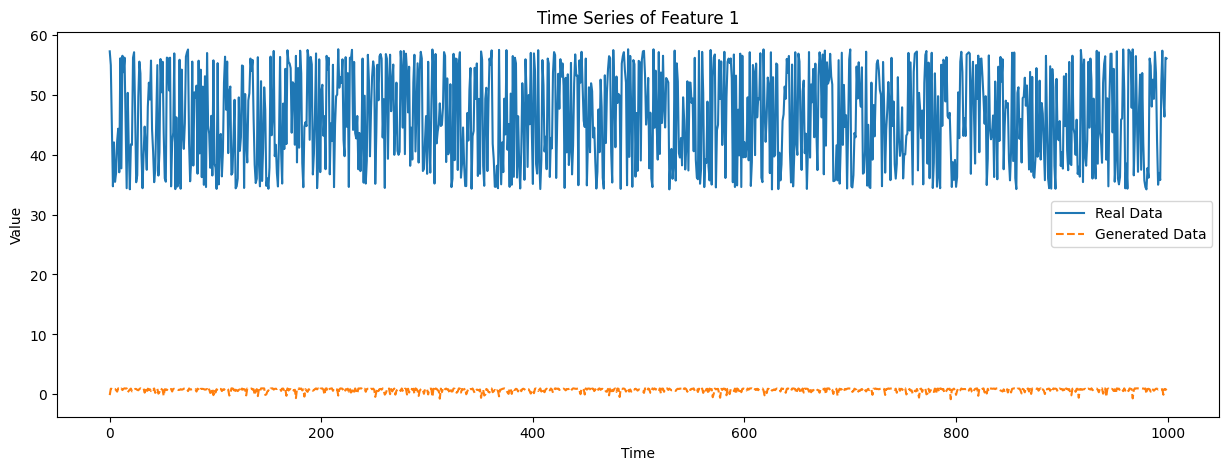

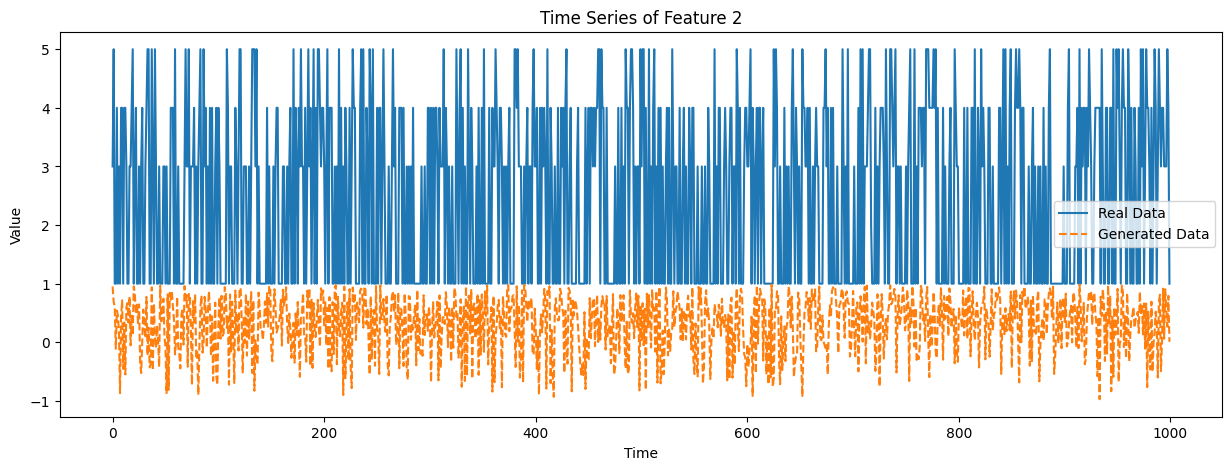

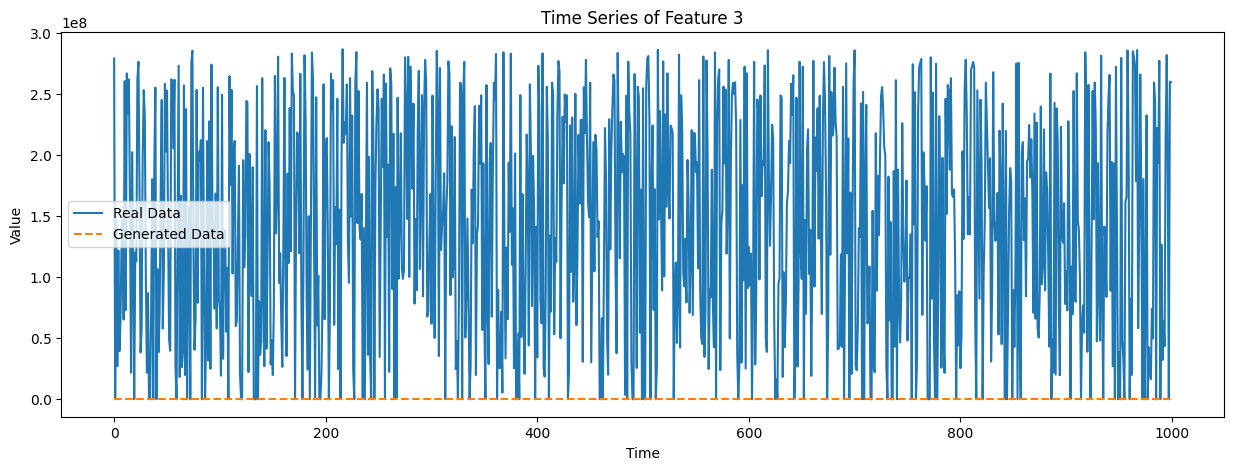

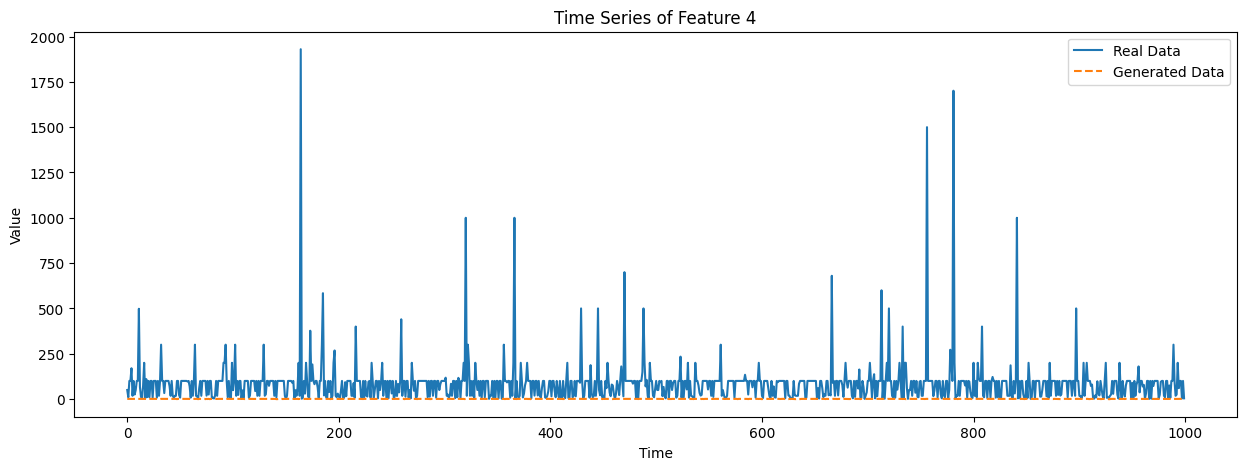

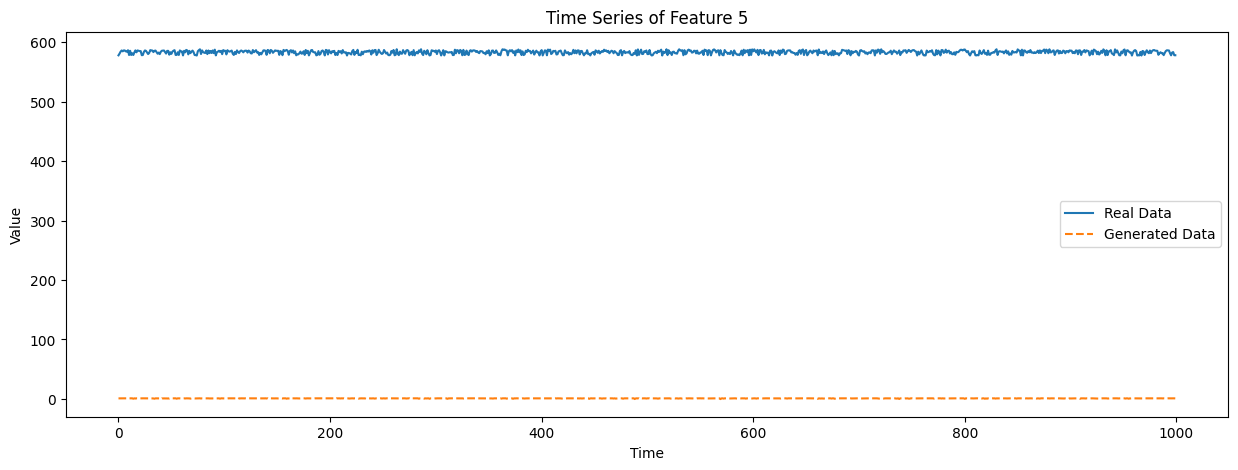

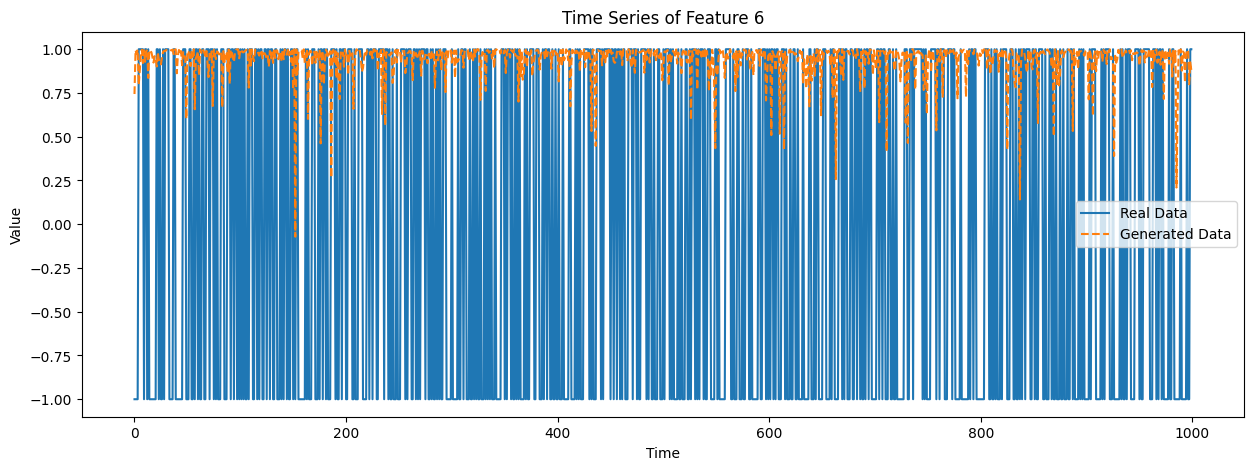

In [10]:
# Plot the time series for comparison
def plot_time_series(real_data, generated_data, title):
    plt.figure(figsize=(15, 5))
    plt.plot(real_data, label='Real Data')
    plt.plot(generated_data, label='Generated Data', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Plot time series of the generated data vs real data
for i in range(stock_gan.message_length):
    plot_time_series(real_messages_sample[:, i], generated_messages[:, i], f'Time Series of Feature {i+1}')